In [1]:
import pandahouse as ph
%matplotlib inline
import matplotlib.pyplot as plt

### Задание

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:


**ARPU**\
**ARPAU**\
**CR в покупку**\
**СR активного пользователя в покупку**\
**CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике**\
ARPU считается относительно всех пользователей, попавших в группы.\
Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.\
Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

### Решение

Подключимся к clickhouse

In [2]:
c_d = {'host': ***,
       'database': ***,
       'user': ***,
       'password': ***
       }

Начнём с того, что посмотрим на новые таблицы, проверим на пропущенные значения и дубли:

In [6]:
d2 = '''
SELECT  *
FROM  default.studs
LIMIT 5

'''
df2 = ph.read_clickhouse(query=d2, connection=c_d)
df2

,st_id,test_grp
0,100379,pilot
1,101432,control
2,104818,pilot
3,104885,pilot
4,104966,pilot


In [7]:
d3 = '''
SELECT  st_id, CAST(sale_time as DateTime) AS sale_time, money, subject
FROM  default.final_project_check
LIMIT 5
'''
df3 = ph.read_clickhouse(query=d3, connection=c_d)
df3

,st_id,sale_time,money,subject
0,101432,2021-10-31 04:44:32,85000,Math
1,101432,2021-10-31 12:43:50,65000,Vizualization
2,104885,2021-10-30 17:05:55,65000,Vizualization
3,104885,2021-10-30 22:49:33,75000,Statistics
4,106464,2021-10-31 13:17:13,85000,Math


1) На основание таблицы default.peas определим активных пользователей в общем, и по математике отдельно\
Будут колонки: st_id, status_all, status_math\
2) На основание таблицу default.final_project_check определим доход по каждому пользователю, и доход по отдельно по пользователю математику\
Будут колонки: st_id, all_money, math_money\
3) Присоединим эти данные к таблице default.studs, используя left join, что бы оставить только студентов входящих в наши группы\
3) Сгруппируем данные по группам и для каждой группы рассчитаем метрики, для этого используем следующие формулы:


**ARPU**  = общая сумма по столбцу money / количество пользователей  в группе\
**ARPAU** = общая сумма по столбцу money / количество платящих пользователей  в группе\
**СR активного пользователя в покупку** = количество пользователей купивших полный доступ/ общее количество пользователей\
**CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике**  = количество пользователей купивших полный доступ к курсу по математике/ общее количество пользователей проходящих курс по математике


### 1.  На основание таблицы default.peas определим активных пользователей в общем, и по математике отдельно
Будут колонки: st_id, status_all, status_math

1) Напишем код для статуса по математике

In [8]:
d_math = '''
SELECT  st_id, sum(correct) >=2 AS status_math 
FROM  default.peas
WHERE subject = 'Math' AND correct = 1
GROUP BY st_id
'''
df_math = ph.read_clickhouse(query=d_math, connection=c_d)
df_math.head(6)

,st_id,status_math
0,906006,1
1,703545,1
2,335410,1
3,385682,1
4,323060,1
5,563039,0


In [9]:
d_all = '''
SELECT  st_id, sum(correct) > 10 AS status_all 
FROM  default.peas
WHERE correct = 1
GROUP BY st_id

'''
status_all = ph.read_clickhouse(query=d_all, connection=c_d)
status_all.head(5)

,st_id,status_all
0,414769,1
1,878110,0
2,700123,1
3,171209,1
4,289442,1


2) Напишем код для остальных статусов\
3) Объединим эти 2 таблицы в одну

In [10]:
d_status = ''' 
SELECT A.st_id AS st_id, status_math, status_all
FROM
     (
        SELECT  st_id, sum(correct) >= 2 AS status_math 
        FROM  default.peas
        WHERE subject = 'Math' and correct = 1
        GROUP BY st_id 
    ) as A
LEFT JOIN
     (
        SELECT  st_id, sum(correct) > 10 AS status_all 
        FROM  default.peas
        WHERE correct = 1
        GROUP BY st_id
    ) as B
ON
    A.st_id = B.st_id

'''


In [11]:
status = ph.read_clickhouse(query=d_status, connection=c_d)
status.head(5)

,st_id,status_math,status_all
0,906006,1,0
1,703545,1,1
2,335410,1,0
3,385682,1,1
4,323060,1,1


### 2. На основание таблицу default.final_project_check определим доход по каждому пользователю, и доход по отдельно по пользователю математику
Будут колонки: st_id, all_money, math_money

In [12]:
m_math = '''
SELECT  st_id, sum(money) AS money_math 
FROM  default.final_project_check
WHERE subject = 'Math'
GROUP BY st_id
'''
mf_math = ph.read_clickhouse(query=m_math, connection=c_d)
mf_math.head(6)

,st_id,money_math
0,270197,85000
1,106464,85000
2,668205,85000
3,770149,85000
4,425496,85000
5,750680,85000


In [13]:
m_all = '''
SELECT  st_id, sum(money) AS money_all 
FROM  default.final_project_check
GROUP BY st_id
'''
mf_all = ph.read_clickhouse(query=m_all, connection=c_d)
mf_all.head(5)

,st_id,money_all
0,270197,225000
1,287212,135000
2,619784,100000
3,106464,85000
4,668205,85000


In [14]:
d_money = ''' 
SELECT A2.st_id AS st_id, money_math, money_all
FROM
     (
        SELECT  st_id, sum(money) AS money_all 
        FROM  default.final_project_check
        GROUP BY st_id 
    ) AS A2
LEFT JOIN
     (
        SELECT  st_id, sum(money) AS money_math 
        FROM  default.final_project_check
        WHERE subject = 'Math'
        GROUP BY st_id
    ) AS B2
ON
    A2.st_id = B2.st_id

'''
money = ph.read_clickhouse(query=d_money, connection=c_d)
money.head(5)

,st_id,money_math,money_all
0,270197,85000,225000
1,287212,0,135000
2,619784,0,100000
3,106464,85000,85000
4,668205,85000,85000


### 3. Присоединим эти данные к таблице default.studs, используя left join, что бы оставить только студентов входящих в наши группы

In [15]:
d2 = '''
SELECT  *
FROM  default.studs
LIMIT 5

'''
df2 = ph.read_clickhouse(query=d2, connection=c_d)
df2

,st_id,test_grp
0,100379,pilot
1,101432,control
2,104818,pilot
3,104885,pilot
4,104966,pilot


In [16]:
d_full_table = '''
SELECT 
A3.st_id as st_id, 
A3.test_grp as test_grp, 
A.status_math as status_math, 
A.status_all as status_all, 
A2.money_math as money_math,
A2.money_all as money_all

FROM
    (
        SELECT  *
        FROM  default.studs
    ) as A3
LEFT JOIN 
    (
    SELECT A.st_id as st_id, status_math, status_all
    FROM
        (
            SELECT  st_id, sum(correct) >= 2 as status_math 
            FROM  default.peas
            WHERE subject = 'Math' and correct = 1
            GROUP BY st_id 
        ) as A
    LEFT JOIN
        (
            SELECT  st_id, sum(correct) >10 as status_all 
            FROM  default.peas
            WHERE correct = 1
            GROUP BY st_id
        ) as B
    ON
        A.st_id = B.st_id
    ) as A
ON A3.st_id = A.st_id
LEFT JOIN
    (
    SELECT A2.st_id as st_id, money_math, money_all
    FROM
            (
                SELECT  st_id, sum(money) as money_all 
                FROM  default.final_project_check
                GROUP BY st_id 
            ) as A2
        LEFT JOIN
            (
                SELECT  st_id, sum(money) as money_math 
                FROM  default.final_project_check
                WHERE subject = 'Math'
                GROUP BY st_id
            ) as B2
        ON
            A2.st_id = B2.st_id
    ) as A2
ON A3.st_id = A2.st_id

'''
full_table = ph.read_clickhouse(query=d_full_table, connection=c_d)
full_table.head(5)

,st_id,test_grp,status_math,status_all,money_math,money_all
0,100379,pilot,0,0,0,0
1,101432,control,0,0,85000,150000
2,104818,pilot,0,0,0,0
3,104885,pilot,0,0,0,140000
4,104966,pilot,0,0,0,0


### 4. Сгруппируем данные по группам и для каждой группы рассчитаем метрики, для этого используем следующие формулы:

**ARPU**  = общая сумма по столбцу money / количество пользователей  в группе\
**ARPAU** = общая сумма по столбцу money / количество платящих пользователей  в группе\
**СR активного пользователя в покупку** = количество активных пользователей купивших полный доступ/ общее количество активных пользователей\
**CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике**  = количество пользователей купивших полный доступ к курсу по математике/ общее количество активных  пользователей проходящих курс по математике

In [17]:
d_final = '''
SELECT
test_grp,
ROUND(SUM(money_all)/COUNT(st_id),0) as ARPU,
ROUND(sUM(money_all)/COUNT(CASE WHEN money_all <> 0 THEN 1 END),0) AS ARPPU,
ROUND(COUNT((CASE WHEN money_all <> 0 AND status_all <> 0 THEN 1 END))/
(COUNT(CASE WHEN status_all <> 0 THEN 1 END)),2) as CR_all,
ROUND(COUNT((CASE WHEN money_math <> 0 AND status_math <> 0 THEN 1 END))/
(COUNT(CASE WHEN status_math <> 0 THEN 1 END)),2) as CR_math

 
FROM 
(
SELECT 
A3.st_id as st_id, 
A3.test_grp as test_grp, 
A.status_math as status_math, 
A.status_all as status_all, 
A2.money_math as money_math,
A2.money_all as money_all

FROM
    (
        SELECT  *
        FROM  default.studs
    ) as A3
LEFT JOIN 
    (
    SELECT A.st_id as st_id, status_math, status_all
    FROM
        (
            SELECT  st_id, sum(correct) >= 2 as status_math 
            FROM  default.peas
            WHERE subject = 'Math' and correct = 1
            GROUP BY st_id 
        ) as A
    LEFT JOIN
        (
            SELECT  st_id, sum(correct) >10 as status_all 
            FROM  default.peas
            WHERE correct = 1
            GROUP BY st_id
        ) as B
    ON
        A.st_id = B.st_id
    ) as A
ON A3.st_id = A.st_id
LEFT JOIN
    (
    SELECT A2.st_id as st_id, money_math, money_all
    FROM
            (
                SELECT  st_id, sum(money) as money_all 
                FROM  default.final_project_check
                GROUP BY st_id 
            ) as A2
        LEFT JOIN
            (
                SELECT  st_id, sum(money) as money_math 
                FROM  default.final_project_check
                WHERE subject = 'Math'
                GROUP BY st_id
            ) as B2
        ON
            A2.st_id = B2.st_id
    ) as A2
ON A3.st_id = A2.st_id
)
GROUP BY test_grp


'''
final_table = ph.read_clickhouse(query=d_final, connection=c_d)
final_table

,test_grp,ARPU,ARPPU,CR_all,CR_math
0,control,4541.0,92333.0,0.12,0.06
1,pilot,11508.0,106094.0,0.17,0.10


### Вывод
Исходя из полученных данных, явно виден значительный рост всех метрик после внесений доработок в процедуру оплаты. **Новый экран оплаты рекомендуется к оперативному внедрению**

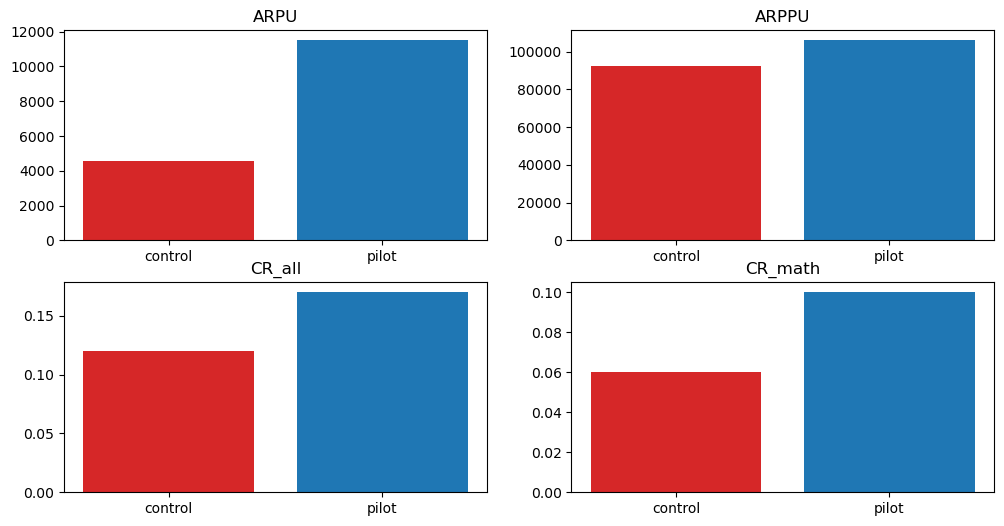

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

axs[0, 0].set_title('ARPU')
axs[0, 1].set_title('ARPPU')
axs[1, 0].set_title('CR_all')
axs[1, 1].set_title('CR_math')

axs[0, 0].bar(final_table.test_grp, final_table.ARPU, color=['tab:red', 'tab:blue'])
axs[0, 1].bar(final_table.test_grp, final_table.ARPPU, color=['tab:red', 'tab:blue'])
axs[1, 0].bar(final_table.test_grp, final_table.CR_all, color=['tab:red', 'tab:blue'])
axs[1, 1].bar(final_table.test_grp, final_table.CR_math, color=['tab:red', 'tab:blue'])

plt.show()
